## Code used for cleaning up and organizing the log results from MOA Multithread Ensembles

- Run ./chunk_pre.sh <Folder with chunk logs\> > file.csv
- Import and show
- Functions format_table_excel_* will either print (show) or (copy to) clipboard a df in the suggested format for annalysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

***
## Parsing preliminary results to find maximum rate and acc comparison

In [2]:
def parse_folder_to_file(folder, outfilename):
    %cd ../results/
    directory = os.fsencode(folder)
    header_printed = False

    with open(f"{outfilename}.csv", "w+") as output:
        output.write('dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change\n')
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                s = parse(f'{os.fsdecode(directory)}/{filename}')
                output.write(f"{s}\n")

In [3]:
def parse(fname):
    columns = []
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    pstr = ''
    spname = fname.split('/')[-1].split('-')[:-1]
    spline = []
    got = False
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                pstr += str(spline[c]) + ','
            pstr += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        else:
            for c in columns:
                pstr += str(spline[c]) + ','
            if len(columns) == 5:
                pstr += '0,'
#         if not header_printed:
#             head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
#             pstr = f"{head}\n{pstr}"
#             header_printed = True
        return (pstr[:-1])

In [4]:
parse_folder_to_file('Xeon/en16/getrates-16', '../scripts/data-xeon')
# parse_folder_to_file('acc-small', '../scripts/data-acc')

/home/cassales/Documents/Parallel-Classifier-MOA/results


In [5]:
def load_df(filename):
    df = pd.read_csv(filename)
    return select_columns_and_rename_values(df)

In [6]:
def select_columns_and_rename_values(df):
    df = df.loc[:,['dataset', 'algorithm', 'ensemble_size', 'cores', 'batch_size', 'instances', 'time', 'acc']]
    df['algorithm'] = df["algorithm"].str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df["algorithm"].str.replace("ARF$", "ARFSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB+")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [7]:
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

## Finding rate

In [8]:
def calculate_rate(desired_esize):
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    file_algs = {'ARF': 'ARF', 'LBag': 'LBag', 'SRP': 'SRP', 'OBAdwin': 'OBagAd', 'OBASHT':'OBagASHT', 'OB': 'OBag'}
    for ds in df.dataset.unique():
        dsdf = df[df.dataset == ds]
        for alg in algorithms:
            s = f'X $1{ds}.arff {file_algs[alg]}'
            adf = filter_by_substring_algorithm(dsdf, alg)
#             if alg == 'LBag' and ds == 'airlines':
#                 display(adf)
            dfres = adf[adf.ensemble_size == desired_esize]
#             display(dfres)
            # get sequential
            seq_rate = list((dfres[(dfres.batch_size == 1) & (dfres.cores == 1)].IPS))[0]
            # get runper
            runper_rate = list(dfres[(dfres.batch_size == 1) & (dfres.cores != 1)].IPS)[0]
            # get MB
            mb_rate = list(dfres[(dfres.batch_size == 500) & (dfres.cores != 1)].IPS)[0]
            #we have max rates, now we need 10, 50 and 90
            if mb_rate != 'NaN':
                #10
                print(f'{s} {int(0.9*seq_rate)} {int(0.9*runper_rate)} {int(0.9*mb_rate)}')
                #50
                print(f'{s} {int(0.5*seq_rate)} {int(0.5*runper_rate)} {int(0.5*mb_rate)}')
                #90
                print(f'{s} {int(0.1*seq_rate)} {int(0.1*runper_rate)} {int(0.1*mb_rate)}')

In [9]:
df = load_df('../scripts/data-xeon.csv')
df['IPS'] = df['instances'] / df['time']

In [10]:
print("Copy the following lines to the end of the script used to run the experimets\n")
calculate_rate(100)

Copy the following lines to the end of the script used to run the experimets

X $1kyoto_binary.arff ARF 954 823 4807
X $1kyoto_binary.arff ARF 530 457 2671
X $1kyoto_binary.arff ARF 106 91 534
X $1kyoto_binary.arff LBag 1213 765 4361
X $1kyoto_binary.arff LBag 673 425 2422
X $1kyoto_binary.arff LBag 134 85 484
X $1kyoto_binary.arff SRP 587 542 2324
X $1kyoto_binary.arff SRP 326 301 1291
X $1kyoto_binary.arff SRP 65 60 258
X $1kyoto_binary.arff OBagAd 3060 935 6518
X $1kyoto_binary.arff OBagAd 1700 519 3621
X $1kyoto_binary.arff OBagAd 340 103 724
X $1kyoto_binary.arff OBagASHT 3564 1005 7571
X $1kyoto_binary.arff OBagASHT 1980 558 4206
X $1kyoto_binary.arff OBagASHT 396 111 841
X $1kyoto_binary.arff OBag 3177 955 5848
X $1kyoto_binary.arff OBag 1765 530 3249
X $1kyoto_binary.arff OBag 353 106 649
X $1airlines.arff ARF 161 240 1035
X $1airlines.arff ARF 89 133 575
X $1airlines.arff ARF 17 26 115
X $1airlines.arff LBag 146 344 1415
X $1airlines.arff LBag 81 191 786
X $1airlines.arff LBag

***
#

#

#

#

## Energy processing

# MOA logs

In [11]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [12]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate']] 

## Energy Data

In [13]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [14]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')[1:]
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
#                 if method not in d[algorithm]:
#                     d[algorithm][method] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [15]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
#                             for k6, v6 in v5.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [16]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH logs

In [17]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    dataset, alg, rate = line.split('-')[1:]
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# RUN MOTHERFUCKER

%cd pi
d = {}
df = load_Wmeas(f'energy/Wmeasure.log')
exper_order_to_dict(f'energy/exper_order.log')
d = populate_dict(d)
adf = append_dict_to_df(d, df)

In [18]:
%pwd

'/home/cassales/Documents/Parallel-Classifier-MOA/results'

In [19]:
d = {}
header_printed = False
moaDF = read_MOA("Xeon/en16/channel_16", "Xeon/en16/inst-and-delay.csv")
measureDF = load_Wmeas(f'Xeon/en16/xeon-16.log')
d = exper_order_to_dict(f'Xeon/en16/exper_order_xeon_16.log', d)
d = populate_dict(d, measureDF)
mdf = append_dict_to_df(d)
sshDF = parse_SSH(f'Xeon/en16/ssh-log')

In [20]:
#join dfs
finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size'])
finaldf = finaldf.merge(sshDF, on=['algorithm', 'dataset', 'inc_rate'])
finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
finaldf['JPI'] = finaldf['joules'] / finaldf['instances']
# finaldf['JP1kI'] = finaldf['joules'] / (finaldf['instances']/1000)
# finaldf['JPIoriginal'] = finaldf['JPI']
# finaldf['JPI'] = finaldf['JP1kI']
# finaldf

### Add PERC column to identify if it used 90, 50 or 10% max rate

In [21]:
tdf = finaldf.sort_values(by=['dataset','algorithm','inc_rate'], ascending=False)
tdf['PERC'] = 0
masks = {'90':[], '50': [], '10': []}
for k, v in zip(masks.keys(), [0, 1, 2]):
#         x = 1 if i % 3 == v else 0
    for i in range(len(tdf)):
        masks[k].append(i % 3 == v)
tdf.loc[masks['90'],'PERC'] = '90'
tdf.loc[masks['50'],'PERC'] = '50'
tdf.loc[masks['10'],'PERC'] = '10'
# tdf.head()

### Show DFs for each algorithm and dataset, divided by rate

In [22]:
algs = ['Ada', 'L', 'Patch', 'Adwin', 'ASHT', 'OzaBag']
datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
for k in ['90', '50', '10']:
#     print(f"\n\n\n\n{k}")
    energy = tdf[tdf.PERC == k]
    for ds in energy.dataset.unique():
        for alg in algs:
#             auxdf = energy[(energy.dataset == ds) & (energy.algorithm.str.contains(alg))]
            auxdf = filter_by_substring_algorithm(energy[energy.dataset == ds], alg)
#             display(auxdf)
#             if alg == 'Patch' or alg == 'Ada':
#                 display(auxdf[['algorithm','dataset','cores','batch_size','prod_rate','out_rate','instances','time','joules','JPI', 'JP1kI']].sort_values(['cores','batch_size']))
#         auxdf = energy[(energy.dataset == ds) & (~energy.algorithm.str.contains('|'.join(algs)))]
#         display(auxdf[['algorithm','dataset','cores','batch_size','prod_rate','out_rate','instances','time','joules','JPI', 'JP1kI']].sort_values(['cores','batch_size']))

# Showing and preparing for graphs

In [23]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [24]:
def rename_columns_by_rate(df):
#     display(df)
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}",
                              "delay": f"delay_{rate}", "joules": f"joules_{rate}", "JPI": f"JPI_{rate}"})

In [25]:
def my_norm(df, x='90MB'):
    mdf = df.iloc[:,[0,1,15,30,45]]
    if x == '90MB':
        thisisone = mdf.iloc[2,4]
#     else:
    elif x == '10S':
        thisisone = mdf.iloc[0,2]
    else:
#         10P
        thisisone = mdf.iloc[1,2]
    for i in ['JPI_10','JPI_50','JPI_90']:
           df[i] = df[i]/thisisone
#     display(df.iloc[:,[0,1,15,30,45]])
    return df.iloc[:,[0,1,15,30,45,7,22,37]]

linhas pretas (solida, tracejada, pontilhada)

JPI em barras (3 barras por rate)

In [26]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
#     display(df)
    width = 0.20
    alg_order = ['Sequential', 'B1', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':']
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    for i in range(3):
        adf = df.iloc[[i]]
        values_j = [adf.JPI_10.iloc[0], adf.JPI_50.iloc[0], adf.JPI_90.iloc[0]]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')
            
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
#         ax.set_xlabel('Rate')
    
    if ylabels:
        ax.set_ylabel(ds)
#         ax.set_ylabel('JPI')
#         ax_r.set_ylabel('delay')
        
    if last:
        ax.set_ymargin(2)
    
    for i in range(3):
        adf = df.iloc[[i]]
        values_d = [adf.delay_10.iloc[0], adf.delay_50.iloc[0], adf.delay_90.iloc[0]]
        values_d = [x/1000 for x in values_d]
        if bar:
            linfo = f'k{line_format[i]}'
        lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [27]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
#     print(f'aux {bar}')
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
        for rt in rates:
            if rt == '10':
#                 display(dsalgdf)
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if alg == algs[-1]:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [28]:
def gen_graph(bars=False, share_y='row', log_y=False, norm=False):
#     print(f'gen {bars}')
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm', 'kyoto_binary']
    print(share_y)
    fig, axis = plt.subplots(len(datasets), 6, figsize=(12,9), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = tdf[tdf.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=6, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=0.2)
    filename = 'bars-all-4x1-JPI-delay.eps' if bars else 'all-4x1-JPI-delay.eps'
    plt.savefig(f'Xeon-{filename}', pad_inches=0.2, bbox_inches='tight')

In [29]:
rates = ['10', '50', '90']
algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
ratio = True
# filtra algoritmo
for alg in algs:
#         line = alg + ' & $\Delta$ '
    line = alg + '  '
    algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
    # filtra dataset
    for ds in datasets:
        dsalgdf = algdf[algdf.dataset == ds]
#         display(dsalgdf.head())
        # "junta"
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
#         showdf = showdf[['algorithm','dataset','cores','batch_size','JPI_10','JPI_50','JPI_90']]
#         display(showdf)
        for i in ['10', '50', '90']:
            minoutro = min(showdf[showdf.batch_size == 1][f'JPI_{i}'])
#             print(f"JPI_{i} minoutro {minoutro}")
            val = ((showdf[showdf.batch_size != 1][f'JPI_{i}'].iloc[0] - minoutro)/minoutro)*100 if ratio else (showdf[showdf.batch_size != 1][f'JPI_{i}'].iloc[0] - minoutro)
            sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
            line += f"& {sval}"
    print(f"{line} \\\\")
# decide se usa Seq ou B1

# gera "linha" do csv para fazer table

Ada  & -76.81 & -75.08 & -75.30 & -67.09 & -66.98 & -67.38 & -81.74 & -80.47 & -80.30 & -82.64 & -83.06 & -82.33 & -80.12 & -77.36 & -80.25  \\
L  & -76.71 & -73.22 & -74.66 & -68.16 & -68.30 & -68.92 & -76.63 & -76.37 & -77.18 & -74.41 & -71.04 & -71.24 & -72.75 & -70.85 & -72.61  \\
Patches  & -71.57 & -66.02 & -67.11 & -71.23 & -67.91 & -67.84 & -81.06 & -78.40 & -76.87 & -86.37 & -81.20 & -82.01 & -73.70 & -71.24 & -68.50  \\
Adwin  & -78.07 & -77.87 & -80.59 & -62.25 & -63.51 & -63.70 & -63.50 & -64.24 & -64.56 & -56.87 & -55.37 & -55.34 & -52.19 & -54.16 & -51.48  \\
ASHT  & -69.59 & -79.84 & -90.91 & -60.48 & -61.67 & -62.04 & -59.17 & -58.30 & -61.89 & -48.61 & -49.38 & -48.26 & -52.69 & -53.35 & -52.64  \\
OzaBag  & -44.22 & -77.02 & -81.20 & -51.25 & -52.18 & -52.74 & -53.49 & -54.06 & -57.95 & -50.19 & -48.38 & -49.19 & -44.46 & -45.90 & -43.83  \\


In [30]:
def table_delta_rates_vert(ratio=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    all_values = []
    # filtra algoritmo
    for alg in algs:
        line = '\hline\n\\multirow{3}{*}{' + alg + '} '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
#         display(algdf)
        # filtra rate
        for rt in rates:
            if rt != '10':
                line += '\\\\\n'
            line += f' & {rt} '
            rtalgdf = rename_columns_by_rate(algdf[algdf.PERC == rt])
            # filtra dataset
            for ds in datasets:
#                 print(ds)
                dsrtalgdf = rtalgdf[rtalgdf.dataset == ds]
#                 display(dsrtalgdf)
                minoutro = min(dsrtalgdf[dsrtalgdf.batch_size == 1][f'JPI_{rt}'])
#                 print(f"JPI_{rt} minoutro {minoutro}")
                val = ((dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro)/minoutro)*100 if ratio else dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro 
                all_values.append(val)
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval} "
        print(f"{line} \\\\")
    print(f'\n\nAverage reduction: {sum(all_values)/len(all_values)}')

In [31]:
table_delta_rates_vert()

\hline
\multirow{3}{*}{Ada}  & 10 & -6.97  & -1.78  & -3.44  & -4.12  & -1.70  \\
 & 50 & -1.49  & -0.38  & -0.70  & -0.91  & -0.33  \\
 & 90 & -1.38  & -0.22  & -0.39  & -0.51  & -0.23   \\
\hline
\multirow{3}{*}{L}  & 10 & -5.20  & -1.40  & -1.82  & -4.81  & -1.26  \\
 & 50 & -0.96  & -0.29  & -0.38  & -0.91  & -0.25  \\
 & 90 & -0.85  & -0.18  & -0.23  & -0.52  & -0.16   \\
\hline
\multirow{3}{*}{Patches}  & 10 & -6.53  & -3.58  & -6.17  & -19.51  & -2.54  \\
 & 50 & -1.29  & -0.68  & -1.13  & -2.78  & -0.50  \\
 & 90 & -1.33  & -0.39  & -0.63  & -1.73  & -0.27   \\
\hline
\multirow{3}{*}{Adwin}  & 10 & -3.54  & -0.47  & -0.63  & -1.75  & -0.34  \\
 & 50 & -0.78  & -0.10  & -0.13  & -0.36  & -0.08  \\
 & 90 & -0.72  & -0.06  & -0.08  & -0.21  & -0.04   \\
\hline
\multirow{3}{*}{ASHT}  & 10 & -1.43  & -0.29  & -0.53  & -1.31  & -0.31  \\
 & 50 & -0.56  & -0.06  & -0.11  & -0.29  & -0.07  \\
 & 90 & -1.33  & -0.04  & -0.07  & -0.16  & -0.04   \\
\hline
\multirow{3}{*}{OzaBag}  & 10 & 

In [32]:
table_delta_rates_vert(ratio=True)

\hline
\multirow{3}{*}{Ada}  & 10 & -76.81  & -67.09  & -81.74  & -82.64  & -80.12  \\
 & 50 & -75.08  & -66.98  & -80.47  & -83.06  & -77.36  \\
 & 90 & -75.30  & -67.38  & -80.30  & -82.33  & -80.25   \\
\hline
\multirow{3}{*}{L}  & 10 & -76.71  & -68.16  & -76.63  & -74.41  & -72.75  \\
 & 50 & -73.22  & -68.30  & -76.37  & -71.04  & -70.85  \\
 & 90 & -74.66  & -68.92  & -77.18  & -71.24  & -72.61   \\
\hline
\multirow{3}{*}{Patches}  & 10 & -71.57  & -71.23  & -81.06  & -86.37  & -73.70  \\
 & 50 & -66.02  & -67.91  & -78.40  & -81.20  & -71.24  \\
 & 90 & -67.11  & -67.84  & -76.87  & -82.01  & -68.50   \\
\hline
\multirow{3}{*}{Adwin}  & 10 & -78.07  & -62.25  & -63.50  & -56.87  & -52.19  \\
 & 50 & -77.87  & -63.51  & -64.24  & -55.37  & -54.16  \\
 & 90 & -80.59  & -63.70  & -64.56  & -55.34  & -51.48   \\
\hline
\multirow{3}{*}{ASHT}  & 10 & -69.59  & -60.48  & -59.17  & -48.61  & -52.69  \\
 & 50 & -79.84  & -61.67  & -58.30  & -49.38  & -53.35  \\
 & 90 & -90.91  & -62.04 

Sharey = row

Linear scale

In [33]:
pd.options.display.max_columns = None

row


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


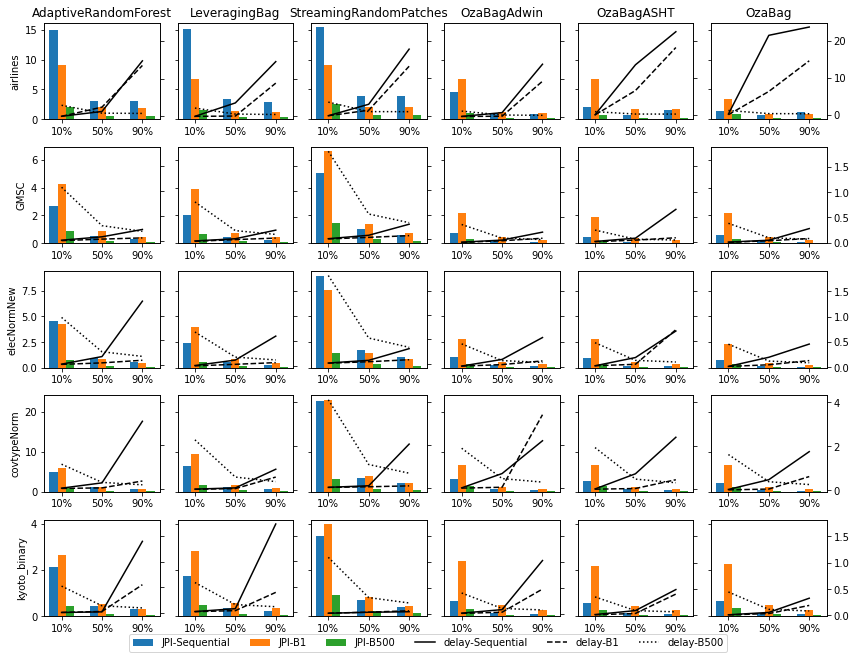

In [34]:
gen_graph(bars=True)

sharey = False

linear scale

False


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


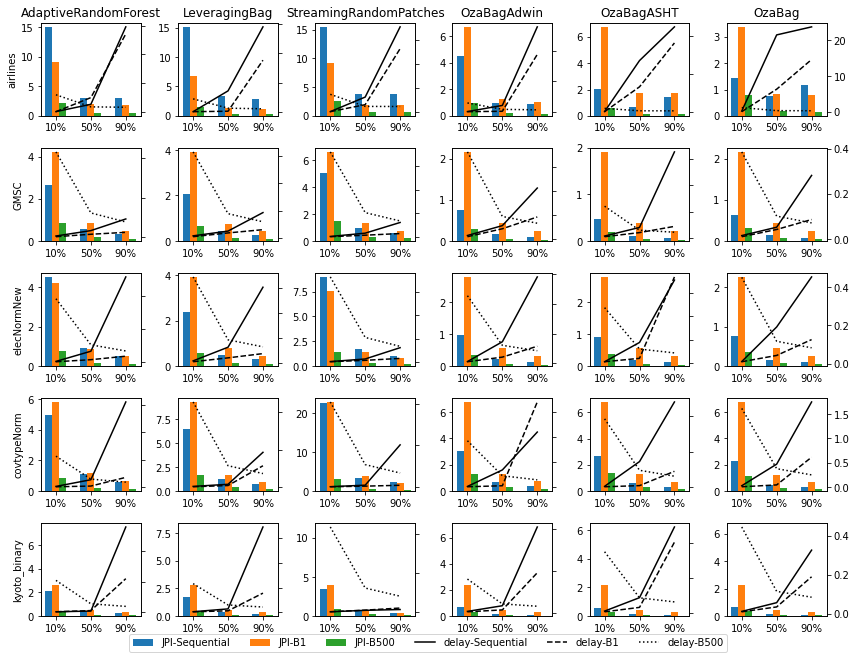

In [35]:
gen_graph(bars=True, share_y=False)

sharey = false

log scale y

False


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


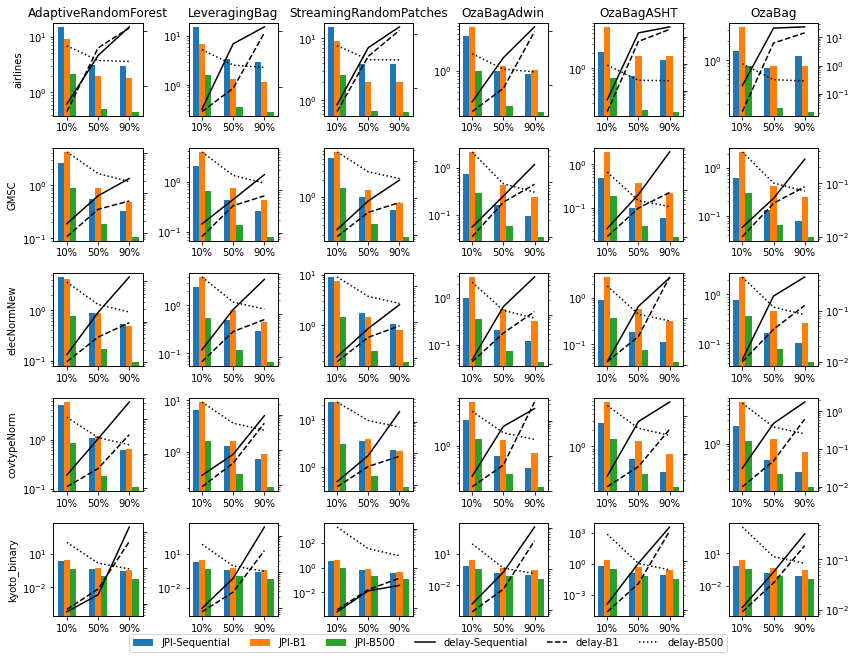

In [36]:
gen_graph(bars=True, share_y=False, log_y=True)

sharey = false

normalizado MB 90

False


IndexError: positional indexers are out-of-bounds

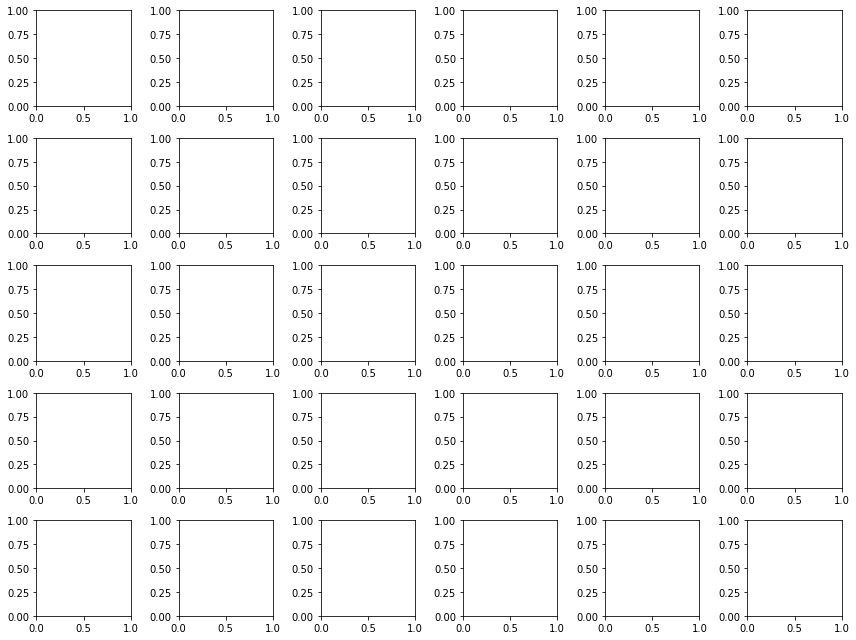

In [37]:
gen_graph(bars=True, share_y=False, log_y=False, norm='90MB')

sharey = false

normalizado Seq10

In [ ]:
gen_graph(bars=True, share_y=False, log_y=False, norm='10S')

In [ ]:
gen_graph(bars=True, share_y=False, log_y=False, norm='10P')

## New chart, Ensemble_size vs (power consumption, accuracy, execution time)

In [ ]:
%pwd

In [ ]:
acc = pd.read_csv("../scripts/data-acc.csv")
acc = acc.loc[:,['dataset','algorithm','ensemble_size','acc']].sort_values(by=['dataset','algorithm','ensemble_size'])
# display(acc.head())
for ds in acc.dataset.unique():
    for alg in acc.algorithm.unique():
        aux = acc[(acc.dataset == ds) & (acc.algorithm == alg)]
        l = list(zip(aux.ensemble_size, aux.acc))
# df = load_df('../scripts/data-pi.csv')
df = pd.read_csv('../scripts/data-pi.csv')
df['IPS'] = df['instances'] / df['time']
df = df[df.cores == 1]
df = df.sort_values(by=['dataset','algorithm','ensemble_size']).drop(columns=['acc'])
df = df.join(acc.set_index(['dataset','algorithm','ensemble_size']), on=['dataset','algorithm','ensemble_size'])
# display(df.head())

measureDF = load_Wmeas(f'pi/more_batch_sizes/Wmeasure-50-100.log')
d = exper_order_to_dict(f'pi/more_batch_sizes/exper_order-50-100.log', d)
populate_dict(d, measureDF)
mdf = append_dict_to_df(d, True)
quero = mdf[(mdf.cores==1) & (mdf.inc_rate == 1)]
# display(quero.head())

fn = lambda row: row.avg_measure * row.duration
col = quero.apply(fn, axis=1) # get column data with an index
quero = quero.assign(avg_times_duration=col.values) # assign values to column 'c'
quero.ensemble_size = quero['ensemble_size'].astype('int64')
finaldf = df.merge(quero, on=['algorithm', 'dataset', 'ensemble_size', 'cores', 'batch_size'])
finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
finaldf['JP1kI'] = finaldf['avg_times_duration'] / (finaldf['instances'] / 1000)
finaldf = finaldf.sort_values(by=['dataset','algorithm','ensemble_size'])[['dataset', 'algorithm', 'ensemble_size', 'IPS', 'acc', 'JP1kI']]
finaldf.head()

add terceiro eixo

In [ ]:
def new_plot(ax, dsdf, my_id, x):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c2 = 'tab:green'
    ax.set_title(f'{dsformalname[ds]}')
    p1, = ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='acc')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.ensemble_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    p2, = ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    make_patch_spines_invisible(ax3)
    ax3.spines["right"].set_visible(True)
    p3, = ax3.plot(x, pd.to_numeric(dsdf.JP1kI), color=c2, label='J per 1k Inst')
    ax3.tick_params(axis='y', labelcolor=c3)
    if int(my_id/2) == 1:
        ax.set_xlabel('Ensemble size')
    ax.set_ylabel('Accuracy %', color=c1)
    ax2.set_ylabel('IPS', color=c2)
    ax3.set_ylabel('IPS', color=c3)
    lines = [p1, p2, p3]
    ax.legend(lines, [l.get_label() for l in lines])


In [ ]:
def gen_graph_initial_peralg_joules(df, display_df=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    filename = f"pi-rates"
    for alg in algorithms:
        fig, axs = plt.subplots(2, 2, figsize=(15,10))
        dfalg = filter_by_substring_algorithm(df, alg)
        fig.suptitle(f'{alg}')
        for ds in datasets:
            display(dfalg)
            dsdf = dfalg[(dfalg.dataset == ds) & (dfalg.cores == 1)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
                if alg == 'SRP':
                    display(dsdf)
            my_id = datasets.index(ds)
            ax = axs[int(my_id/2)][my_id%2]
            new_plot(ax, dsdf, my_id, x)
        plt.savefig(f'{filename}.eps', bbox_inches='tight')

In [ ]:
gen_graph_initial_peralg_joules(finaldf, display)